In [1]:
import os
import glob
import pickle
import numpy as np
import PIL.Image as PILImage
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

In [2]:
files = sorted(glob.glob("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/force_localisation/dataset/data/*"), key=os.path.getmtime)

In [3]:
tactile_full = []
distance_full = []

for index, file in enumerate(files):
    dist = np.load(file + "/force_position.npy")
    tactile_image = np.load(file + "/haptic_finger_data.npy")
    # tactile_image[170:] = 0
    # tactile_image[150:170, 100:150] = 0
    # # tactile_image = tactile_image / 255.0

    tactile_image = tactile_image[:170] # this is for cropped image (sensor base part is deleted instead of blacking)

    # this is for 64x64 input image resolution
    tactile_image = PILImage.fromarray(tactile_image).resize((64, 64), PILImage.Resampling.LANCZOS)
    tactile_image = np.array(tactile_image)
    tactile_image = tactile_image / 255.0
    
    if dist > 0.0:  
        tactile_full.append(tactile_image)
        distance_full.append(dist)
    if dist < 0.0:
        ref_image = tactile_image

In [4]:
distance_full = np.array(distance_full)
tactile_full = np.array([tactile_image - ref_image for tactile_image in tactile_full])
ref_image = np.array(ref_image)

In [5]:
print(tactile_full.shape)
print(distance_full.shape)

(129, 64, 64, 3)
(129,)


In [6]:
# resample the data row with farther force distance
farther_samles_tactile = tactile_full[:18]
farther_sample_distance = distance_full[:18]
tactile_full = np.concatenate((tactile_full, farther_samles_tactile), axis=0)
distance_full = np.concatenate((distance_full, farther_sample_distance), axis=0)

In [7]:
distance_scaler = MinMaxScaler()
distance_scaler.fit(np.reshape(distance_full, (-1, 1)))
distance_full = distance_scaler.transform(np.reshape(distance_full, (-1, 1)))

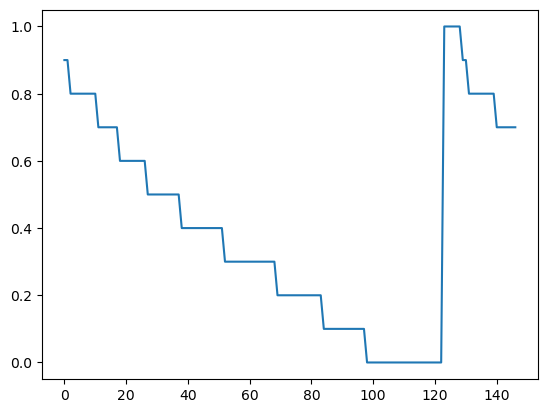

In [8]:
plt.plot(distance_full)

In [7]:
pickle.dump(distance_scaler, open("distance_scaler.pkl", "wb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

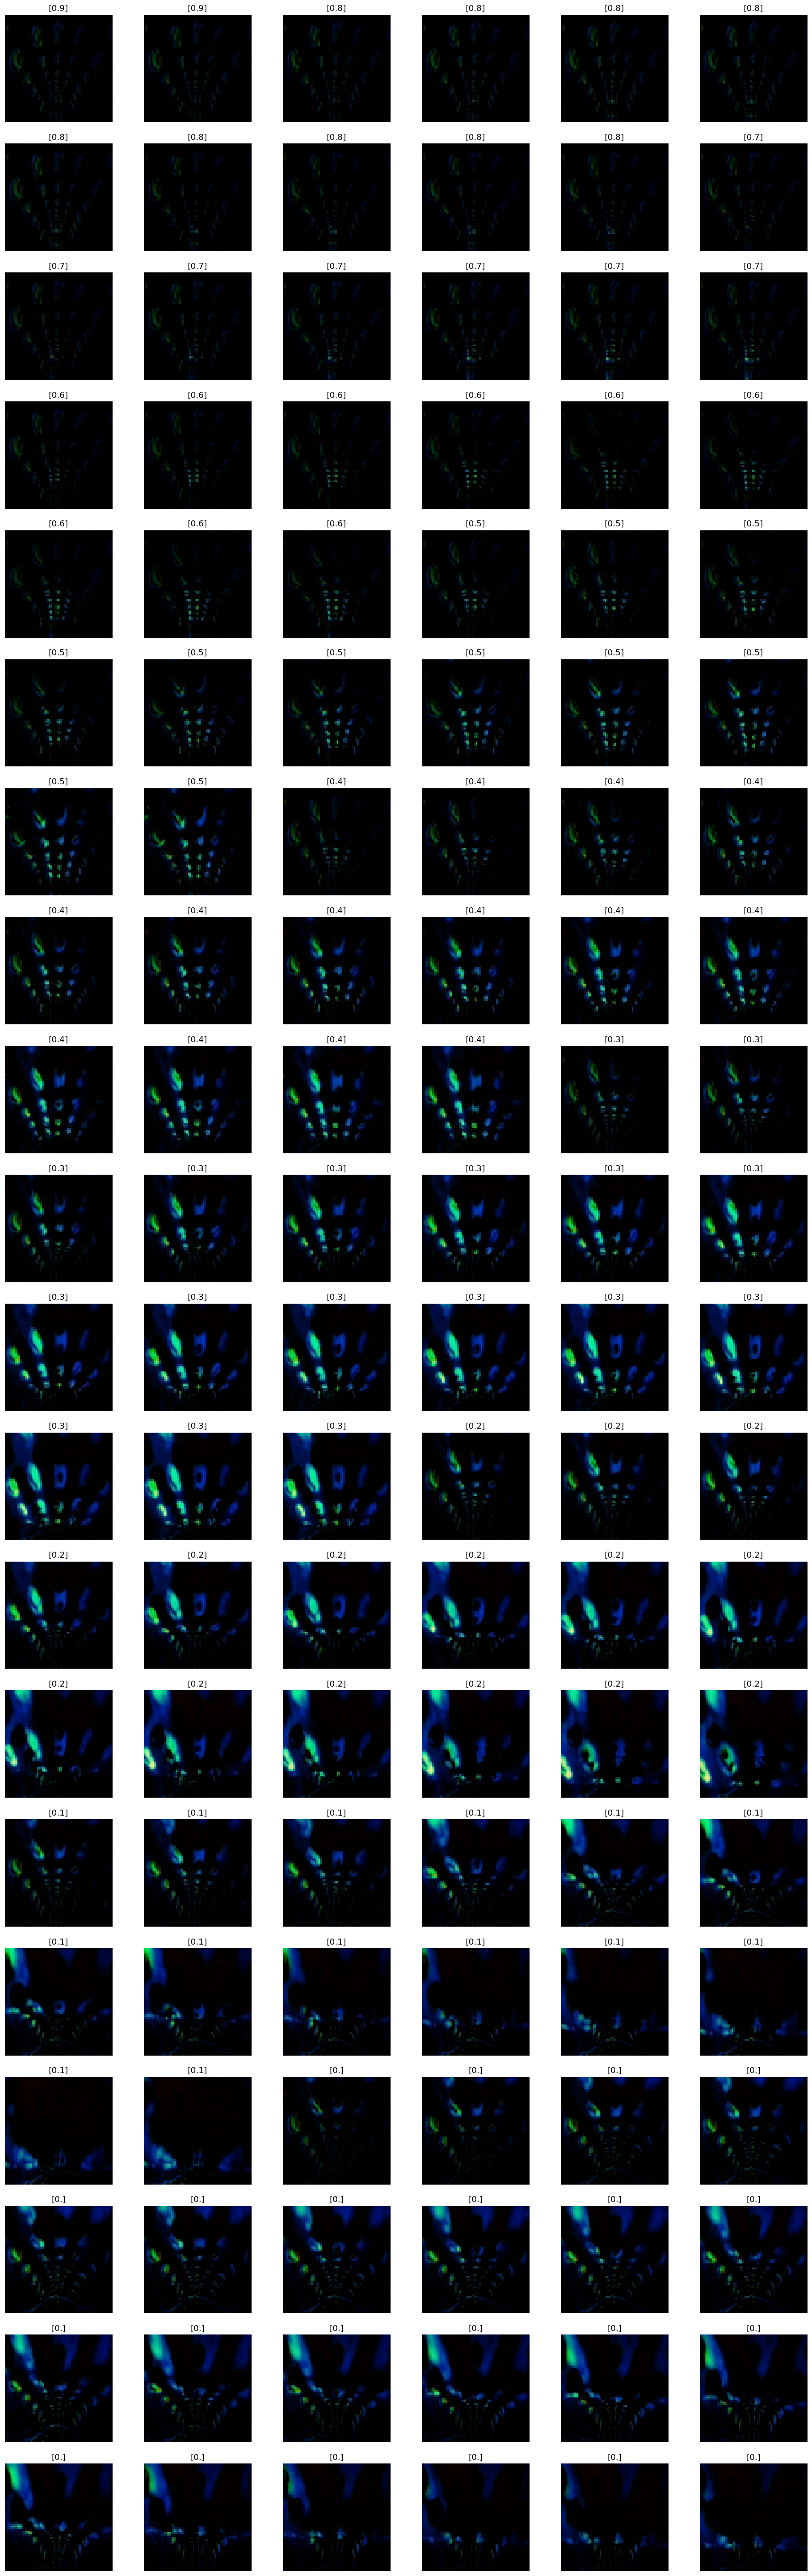

In [9]:
fig, axs = plt.subplots(20, 6, figsize=(21, 200/3))
index = 0
for row in range(20):
    for col in range(6):
        axs[row, col].imshow(tactile_full[index], cmap="YlOrBr")
        axs[row, col].axis('off')
        axs[row, col].set_xticklabels([])
        axs[row, col].set_yticklabels([])
        axs[row, col].set_title(str(distance_full[index]))
        index += 1
plt.show()

In [10]:
class localisation_model(nn.Module):
    
    def __init__(self):
        super(localisation_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(16*64*64, 512) # this is for 256x256
        self.fc1 = nn.Linear(16*16*16, 512) # this is for 64x64
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
    
    def forward(self, tactile):
        x = self.relu(self.maxpool(self.conv1(tactile)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [11]:
tactile_full = torch.from_numpy(tactile_full).permute(0, 3, 1, 2).float()
distance_full = torch.from_numpy(distance_full).float()

In [12]:
indeces = np.arange(len(tactile_full))
np.random.seed(42)
np.random.shuffle(indeces)
tactile_full = tactile_full[indeces]
distance_full = distance_full[indeces]
train_size = 0.9
x_tr, y_tr = tactile_full[:int(train_size*len(tactile_full))], distance_full[:int(train_size*len(tactile_full))]
x_val, y_val = tactile_full[int(train_size*len(tactile_full)):], distance_full[int(train_size*len(tactile_full)):]

In [13]:
localisation_model = localisation_model()
mse_loss = nn.MSELoss()
optimizer = optim.Adam(localisation_model.parameters(), lr=0.001)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(localisation_model))

2115505


In [15]:
predictions = []
loss_tr = []
loss_val = []
epochs = 200

In [16]:
for e in range(epochs):

    localisation_model.train()
    optimizer.zero_grad()
    
    distance_pred = localisation_model(x_tr)

    loss = mse_loss(distance_pred, y_tr)
    loss.backward()
    optimizer.step()

    loss_tr.append(loss.item())

    with torch.no_grad():

        localisation_model.eval()

        distance_pred = localisation_model(x_val)
        loss = mse_loss(distance_pred, y_val)

        loss_val.append(loss.item())

    print("epoch {} | train loss = {:.4f}  |  validation loss = {:.4f}".format(e+1, loss_tr[-1], loss_val[-1]))


epoch 1 | train loss = 0.1833  |  validation loss = 0.0992
epoch 2 | train loss = 0.1244  |  validation loss = 0.1477
epoch 3 | train loss = 0.1070  |  validation loss = 0.1785
epoch 4 | train loss = 0.1140  |  validation loss = 0.1438
epoch 5 | train loss = 0.0970  |  validation loss = 0.1053
epoch 6 | train loss = 0.0864  |  validation loss = 0.0864
epoch 7 | train loss = 0.0871  |  validation loss = 0.0771
epoch 8 | train loss = 0.0825  |  validation loss = 0.0730
epoch 9 | train loss = 0.0710  |  validation loss = 0.0755
epoch 10 | train loss = 0.0587  |  validation loss = 0.0809
epoch 11 | train loss = 0.0505  |  validation loss = 0.0788
epoch 12 | train loss = 0.0441  |  validation loss = 0.0597
epoch 13 | train loss = 0.0350  |  validation loss = 0.0362
epoch 14 | train loss = 0.0307  |  validation loss = 0.0288
epoch 15 | train loss = 0.0290  |  validation loss = 0.0314
epoch 16 | train loss = 0.0268  |  validation loss = 0.0349
epoch 17 | train loss = 0.0271  |  validation los

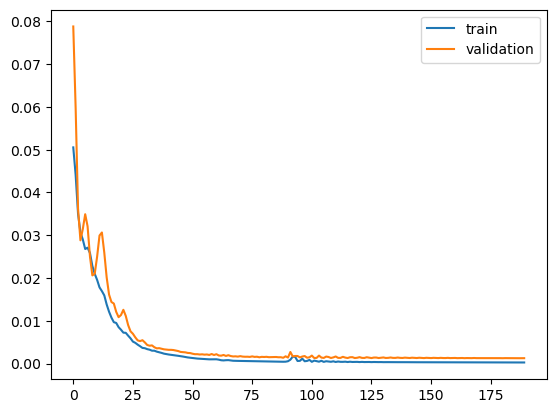

In [17]:
loss_tr = np.array(loss_tr)
loss_val = np.array(loss_val)
plt.plot(loss_tr[10:], label="train")
plt.plot(loss_val[10:], label="validation")
plt.legend()
plt.show()

In [18]:
np.save("cnn_crop64img_tr.npy", loss_tr)
np.save("cnn_crop64img_val.npy", loss_val)

In [19]:
torch.save(localisation_model.state_dict(), "localisation_cnn_crop64.pth")